<a href="https://colab.research.google.com/github/ospinooo/mushsnap-research/blob/master/Mushrooms_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Which GPU?
!nvidia-smi

Mon Jun 22 09:16:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In order to use FastAI correctly in Google Collab we need to undergrade the current versions. There are some errors in the new ones.

In [3]:
# Installing other version because of unnecessary warnings
!pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install "Pillow<7"

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.9MB 23kB/s 
     |████████████████████████████████| 8.8MB 41.0MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 2.1MB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [1]:
import torch
import torchvision
print(torchvision.__version__)
print(torch.__version__)

0.4.0
1.2.0


## Dataset

We need to acces the drive to get the kaggle.json file as it acts such as credentials file to be able to download datasets from Kaggle. We will download the mushrooms clasification dataset.

In [8]:
# Install and activate kaggle
!pip install -q --upgrade kaggle
!mkdir -p ~/.kaggle
!cp drive/'My Drive'/'final project'/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [9]:
# Download
!kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images
# Unzip dataset
!unzip -q mushrooms-classification-common-genuss-images.zip
!ls

100% 1.85G/1.85G [00:19<00:00, 92.4MB/s]
100% 1.85G/1.85G [00:19<00:00, 102MB/s] 
drive	   Mushrooms					      sample_data
mushrooms  mushrooms-classification-common-genuss-images.zip


## Import Libraries

In [36]:
from subprocess import check_output
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import time
import os

from fastai.vision import cnn_learner
from fastai.vision import ImageDataBunch
from fastai.vision import Path
from fastai.vision import get_transforms
from fastai.vision import imagenet_stats
from fastai.vision import models
from fastai.vision import accuracy
from fastai.vision import ClassificationInterpretation

from fastai.metrics import error_rate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

In [ ]:
from fastai.callbacks import ActivationStats
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Setup Dataset

This dataset has not the same purpose of our project but we will study it to get knowledge we could transfer to our project.

In [11]:
classes = ['Boletus','Entoloma','Russula','Suillus','Lactarius','Amanita','Agaricus','Hygrocybe','Cortinarius']

In [12]:
bs = 128

In [13]:
path = Path('Mushrooms')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [28]:
np.random.seed(42)
data = ImageDataBunch.from_folder(
    path, 
    train='.', 
    valid_pct=0.35, 
    ds_tfms=get_transforms(),
    size=224, 
    num_workers=4
).normalize(imagenet_stats)

In [15]:
data.classes

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

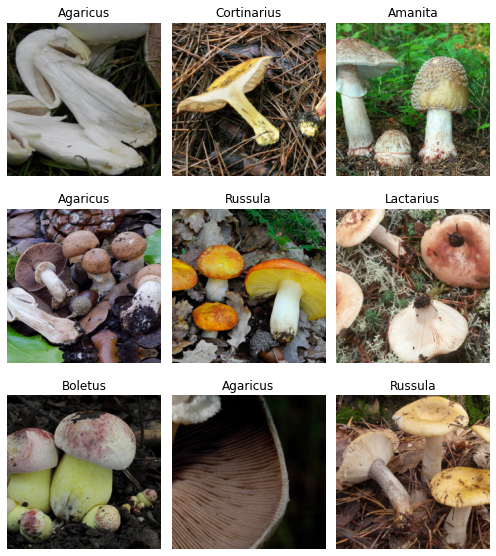

In [16]:
data.show_batch(rows=3, figsize=(7,8))

In [17]:
print("Classes", data.classes)
print("Number of classes: ", data.c)
print("Train dataset size: ", len(data.train_ds))
print("Validation dataset size: ", len(data.valid_ds))

Classes ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']
Number of classes:  9
Train dataset size:  4365
Validation dataset size:  2349


## Training

In [29]:
# Transfer learning from models available in Fastai
learn = cnn_learner(
    data, # DataBunch
    models.resnet50, # Transfer learning
    metrics=accuracy # Metrics
)

In [30]:
# Solve error of loading truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [32]:
learn.fit_one_cycle(4, wd=0.9)

epoch,train_loss,valid_loss,accuracy,time
0,1.628534,0.951998,0.712218,03:37
1,1.049939,0.657299,0.776075,03:34
2,0.745425,0.593460,0.802895,03:36
3,0.576778,0.561752,0.813112,03:35


In [33]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


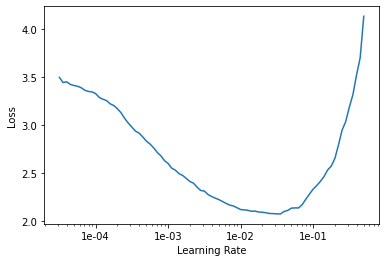

In [21]:
# Range test tool
learn.lr_find(start_lr = slice(1e-5), end_lr=slice(1))
learn.recorder.plot()

In [34]:
learn.unfreeze()

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

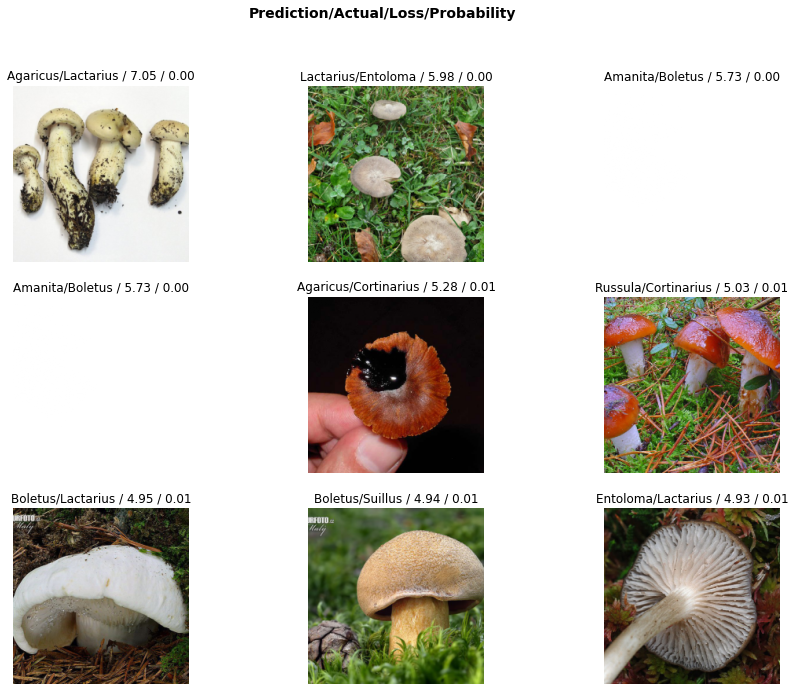

In [38]:
interp.plot_top_losses(9, figsize=(15,11))

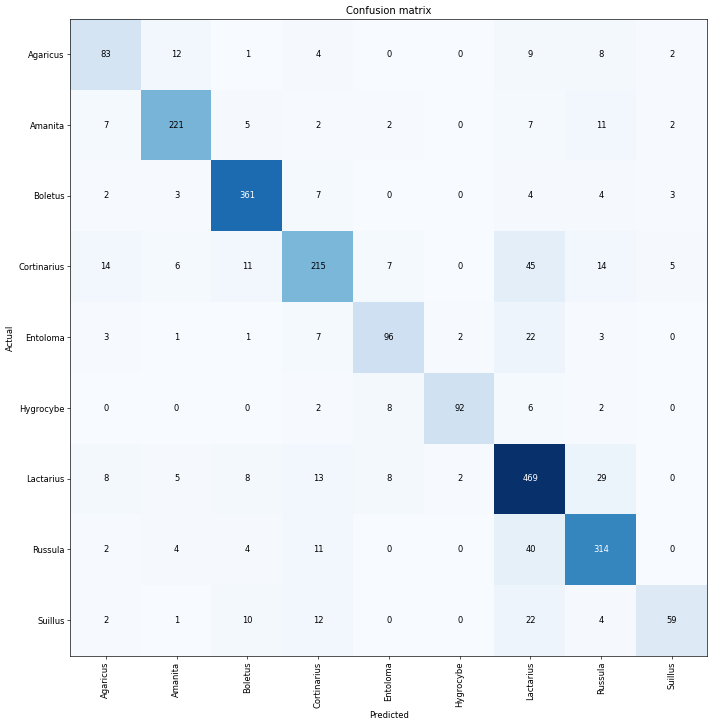

In [39]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)